In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np

In [57]:
values = pd.read_csv("data/values.csv")
values.head()

,Symbol,Date,Close,SimpleReturn,LogReturn,Ret_1W,Ret_2W,Ret_1M,Ret_2M,Norm_Ret,RSI,MACD
0,AAPL,2023-03-30 00:00:00-04:00,160.191223,0.009890,0.009841,1.477877,2.832362,7.679010,8.893734,0.681149,0.669896,3.219354
1,AAPL,2023-03-31 00:00:00-04:00,162.697281,0.015644,0.015523,1.972657,4.269861,8.437710,9.312925,1.070535,0.702587,3.525150
2,AAPL,2023-04-03 00:00:00-04:00,163.950317,0.007702,0.007672,3.385524,3.773536,6.648654,9.384402,0.533946,0.717643,3.824519
3,AAPL,2023-04-04 00:00:00-04:00,163.417526,-0.003250,-0.003255,3.578196,2.832803,5.355684,6.898206,-0.235870,0.701384,3.972980
4,AAPL,2023-04-05 00:00:00-04:00,161.572495,-0.011290,-0.011355,1.321530,2.645182,5.533434,4.283907,-0.814314,0.646739,3.896838


In [58]:
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69898 entries, 0 to 69897
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Symbol        69898 non-null  object 
 1   Date          69898 non-null  object 
 2   Close         69898 non-null  float64
 3   SimpleReturn  69898 non-null  float64
 4   LogReturn     69898 non-null  float64
 5   Ret_1W        69898 non-null  float64
 6   Ret_2W        69898 non-null  float64
 7   Ret_1M        69898 non-null  float64
 8   Ret_2M        69898 non-null  float64
 9   Norm_Ret      69898 non-null  float64
 10  RSI           69898 non-null  float64
 11  MACD          69898 non-null  float64
dtypes: float64(10), object(2)
memory usage: 6.4+ MB


In [59]:
print(values.Symbol.unique())
print(values['Symbol'].nunique())


['AAPL' 'ABBV' 'ABT' 'ACN' 'ADBE' 'AIG' 'AMD' 'AMGN' 'AMT' 'AMZN' 'AVGO'
 'AXP' 'BA' 'BAC' 'BK' 'BKNG' 'BLK' 'BMY' 'BRK-B' 'C' 'CAT' 'CL' 'CMCSA'
 'COF' 'COP' 'COST' 'CRM' 'CSCO' 'CVS' 'CVX' 'DE' 'DHR' 'DIS' 'DUK' 'EMR'
 'FDX' 'GD' 'GE' 'GILD' 'GM' 'GOOGL' 'GS' 'HD' 'HON' 'IBM' 'INTC' 'INTU'
 'ISRG' 'JNJ' 'JPM' 'KO' 'LIN' 'LLY' 'LMT' 'LOW' 'MA' 'MCD' 'MDLZ' 'MDT'
 'MET' 'META' 'MMM' 'MO' 'MRK' 'MS' 'MSFT' 'NEE' 'NFLX' 'NKE' 'NOW' 'NVDA'
 'ORCL' 'PEP' 'PFE' 'PG' 'PLTR' 'PM' 'PYPL' 'QCOM' 'RTX' 'SBUX' 'SCHW'
 'SO' 'SPG' 'T' 'TGT' 'TMO' 'TMUS' 'TSLA' 'TXN' 'UBER' 'UNH' 'UNP' 'UPS'
 'USB' 'V' 'VZ' 'WFC' 'WMT' 'XOM']
100


## Correlation-based static graph

In [60]:
filtered_values = values[['Symbol', 'Date', 'LogReturn']]
filtered_values.head()

,Symbol,Date,LogReturn
0,AAPL,2023-03-30 00:00:00-04:00,0.009841
1,AAPL,2023-03-31 00:00:00-04:00,0.015523
2,AAPL,2023-04-03 00:00:00-04:00,0.007672
3,AAPL,2023-04-04 00:00:00-04:00,-0.003255
4,AAPL,2023-04-05 00:00:00-04:00,-0.011355


In [61]:
# 1. Convert Date to datetime (if it isn't already)
filtered_values['Date'] = pd.to_datetime(filtered_values['Date'], utc=True)

# 2. Normalize to remove time and timezone info (keep only the day)
filtered_values['Date'] = filtered_values['Date'].dt.date

# 3. Handle Potential Duplicates (The other common cause of freezing)
# If you somehow downloaded data twice, drop duplicates to prevent errors
filtered_values = filtered_values.drop_duplicates(subset=['Date', 'Symbol'])

/tmp/ipykernel_2372/1248921063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_values['Date'] = pd.to_datetime(filtered_values['Date'], utc=True)
/tmp/ipykernel_2372/1248921063.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_values['Date'] = filtered_values['Date'].dt.date


In [62]:
# 4. Now Pivot
pivot_df = filtered_values.pivot(index='Date', columns='Symbol', values='LogReturn')

pivot_df.head()

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UBER,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2023-03-30,0.009841,-0.000506,0.004653,0.009669,0.007200,0.022738,0.018457,0.001948,0.013461,0.017306,...,0.010313,0.007409,-0.003674,-0.001986,-0.008147,-0.004219,0.004667,-0.015661,0.009934,0.004852
2023-03-31,0.015523,0.009140,0.021764,0.011082,0.009045,0.010781,0.001327,0.001035,0.015585,0.012568,...,0.016219,0.005368,0.014514,0.015062,0.016784,0.013845,0.005932,0.000000,0.012145,0.001552
2023-04-03,0.007672,0.006567,0.003254,0.000105,-0.013822,0.001191,-0.014905,0.011066,-0.015983,-0.008556,...,-0.007600,0.044692,-0.008583,-0.001393,-0.011439,0.015579,0.008450,0.009055,0.008374,0.057325
2023-04-04,-0.003255,-0.003997,0.011840,0.000000,0.013251,-0.010968,-0.007171,0.012562,0.011618,0.014926,...,-0.002228,-0.001904,-0.018513,-0.016184,-0.016408,-0.005869,0.010904,-0.024421,-0.009868,-0.009604
2023-04-05,-0.011355,0.006364,0.013623,-0.015904,-0.008160,0.007392,-0.035136,0.023319,0.006076,-0.027800,...,-0.008639,0.031884,-0.008562,-0.006368,0.001425,0.002238,0.011534,0.002171,0.016437,0.016982


In [63]:
corr_matrix = pivot_df.corr(method='spearman')
corr_matrix = (corr_matrix - (corr_matrix == 1))  # Remove self-correlation
corr_matrix.head()


Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UBER,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000000,0.079653,0.073709,0.253600,0.348270,0.156331,0.332675,0.177347,0.118148,0.398987,...,0.253473,0.050203,0.231817,0.267372,0.237685,0.297211,0.071332,0.208428,0.156743,0.075973
ABBV,0.079653,0.000000,0.358344,0.177274,0.121197,0.253766,-0.027574,0.495320,0.263000,-0.042642,...,0.108079,0.192201,0.273422,0.312612,0.220274,0.293327,0.272590,0.197162,0.164233,0.174734
ABT,0.073709,0.358344,0.000000,0.208716,0.149391,0.222663,-0.045745,0.316041,0.334126,0.001496,...,0.167285,0.158541,0.362705,0.294741,0.221001,0.368576,0.341393,0.149589,0.219206,0.075152
ACN,0.253600,0.177274,0.208716,0.000000,0.474738,0.267849,0.217030,0.253514,0.139852,0.307714,...,0.209769,0.175306,0.350736,0.324963,0.321019,0.397086,0.111058,0.237227,0.169186,0.070247
ADBE,0.348270,0.121197,0.149391,0.474738,0.000000,0.237909,0.344512,0.173686,0.079551,0.456262,...,0.343446,0.085725,0.250350,0.234782,0.252681,0.382941,0.044579,0.181567,0.110774,0.063764


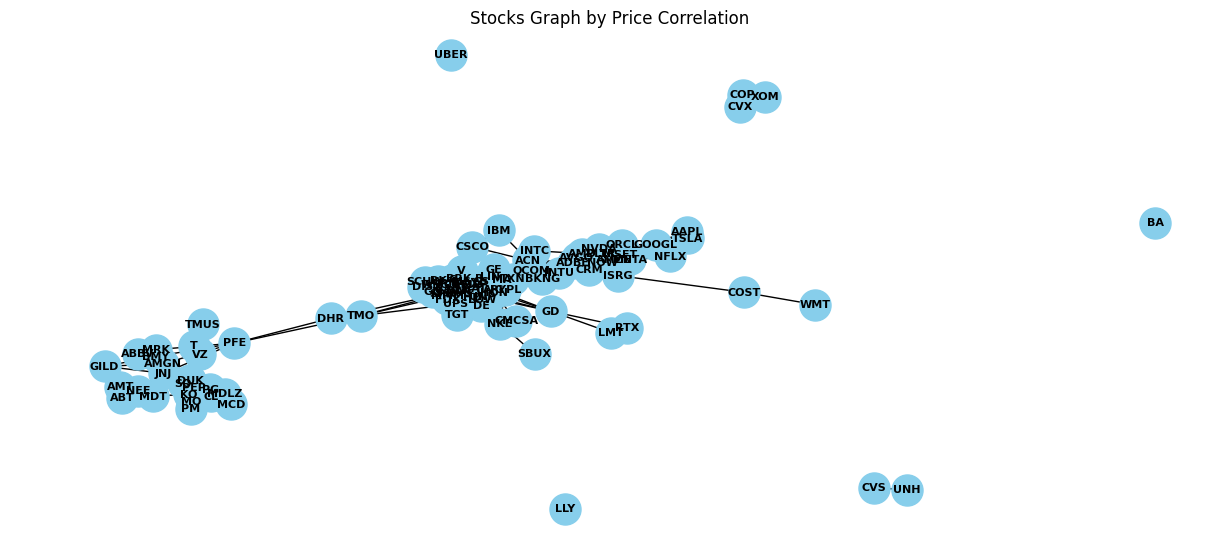

In [64]:
corr_np = corr_matrix.to_numpy()
adj_fundamentals_corr = (corr_np * (abs(corr_np) > 0.4).astype(int))

corr_graph = nx.from_numpy_array(adj_fundamentals_corr)
corr_graph = nx.relabel_nodes(corr_graph, dict(enumerate(corr_matrix.index)))

plt.figure(figsize=(12, 5))
nx.draw(corr_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(corr_graph))
plt.title('Stocks Graph by Price Correlation')
plt.show()

## Graph generation based on correlation of stock prices according to paper

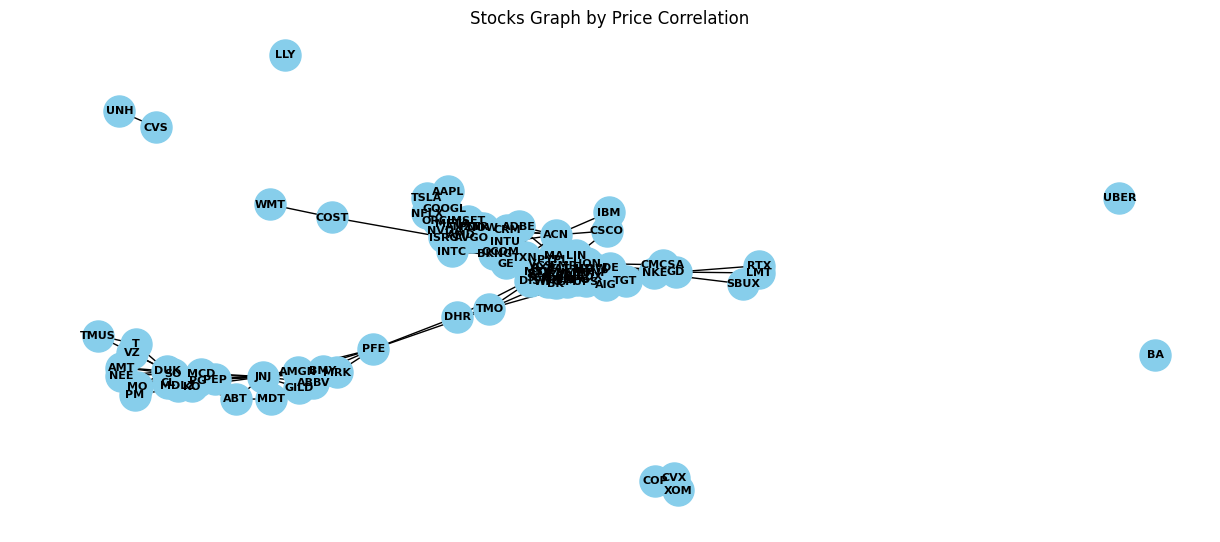

In [65]:
filtered_values = values[['Symbol', 'Date', 'SimpleReturn']]
corr_matrix = pivot_df.corr(method='spearman')
corr_matrix = (corr_matrix - (corr_matrix == 1))  # Remove self-correlation
corr_np = corr_matrix.to_numpy()
adj_fundamentals_corr = (corr_np * (abs(corr_np) > 0.4).astype(int))

corr_graph = nx.from_numpy_array(adj_fundamentals_corr)
corr_graph = nx.relabel_nodes(corr_graph, dict(enumerate(corr_matrix.index)))

plt.figure(figsize=(12, 5))
nx.draw(corr_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(corr_graph))
plt.title('Stocks Graph by Price Correlation')
plt.show()

## Readin generated graph

In [7]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the matrix
adj_matrix = np.load("data/pearson_adj.npy")

# 2. CONVERT to a NetworkX Graph Object (This is the missing step)
G = nx.from_numpy_array(adj_matrix)

# 3. Now draw the Graph object 'G', not the matrix
plt.figure(figsize=(12, 12)) # Increased height for better visibility

# Calculate layout based on the Graph object G
pos = nx.spring_layout(G, k=0.15, iterations=20) 

nx.draw(
    G,                  # Pass G here
    pos=pos,            # Use the calculated layout
    with_labels=True, 
    node_size=500, 
    node_color='skyblue', 
    font_size=8, 
    font_weight='bold', 
    font_color='black',
    edge_color='gray',  # Added explicitly to ensure edges are visible
    alpha=0.7           # Transparency
)

plt.title('Stocks Graph by Price Correlation')
plt.show()

NetworkXError: Input array must be 2D, not 1